# Exercise 4 - Clustering Algorithms

## a) Clustering using K-means

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
class KMeans:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        
    def fit(self, train_x, random_state = 0):
        m = train_x.shape[0]
        np.random.seed(random_state)
        self.centroids = train_x[np.random.choice(m,self.n_clusters,replace=False)]
        while True:
            old_centroids = self.centroids.copy()
            self.labels = self.predict(train_x)
            for cluster_id in range(self.n_clusters):
                cluster = train_x[self.labels == cluster_id]
                if len(cluster):
                    self.centroids[cluster_id] = cluster.mean(axis=0)
            if np.all(old_centroids != self.centroids) : break
                
    def predict(self, points):
        return np.argmin(cdist(points,self.centroids),axis=-1)

In [17]:
def distortion(X,labels,centroids):
    _, label_codes = np.unique(labels,return_inverse=True)
    return np.linalg.norm((X-centroids[label_codes]),axis=-1).mean()

def silhouette_score(X, labels):
    m = X.shape[0]
    clusters = np.unique(labels)
    n_clusters = clusters.shape[0]
    if n_clusters == 1: return -1
    cluster_codes = np.arange(n_clusters)
    dist_mask = labels.reshape(-1,1) == \
        ((labels + cluster_codes.reshape(-1,1))%n_clusters)[:,np.newaxis,:]
    dist_mask[0][np.eye(m).astype(np.bool)] = 0
    dist_mat = cdist(X,X)
    mean_dist = (dist_mask*dist_mat).sum(axis=-1)/dist_mask.sum(axis=-1)
    A = mean_dist[0]
    B = np.min(mean_dist[1:],axis=0)
    return ((B-A)/np.max(np.dstack([A,B]),axis=-1)).mean()

 ## Loading dataset

In [4]:
names = ['s_len', 's_wid', 'p_len', 'p_wid', 'species']
iris_df = pd.read_csv('./datasets/iris.csv', header=None, names=names)
display(iris_df.head())
print(
    f"The data set contains {iris_df.shape[0]} records "
    f"and {iris_df.shape[1]} features.",
    iris_df['species'].value_counts(), sep="\n"
)


,s_len,s_wid,p_len,p_wid,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The data set contains 150 records and 5 features.
versicolor    50
virginica     50
setosa        50
Name: species, dtype: int64


 ## Comparing Clustering against classes

In [14]:
train_x = iris_df.drop("species", axis=1).values
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(train_x)
all_df = iris_df.copy(deep = True)
centroids = pd.DataFrame(kmeans.centroids, columns=names[:-1])
centroids["cluster"] = "centroid"
all_df['cluster'] = kmeans.labels.astype("str")
all_df = pd.concat([all_df, centroids])

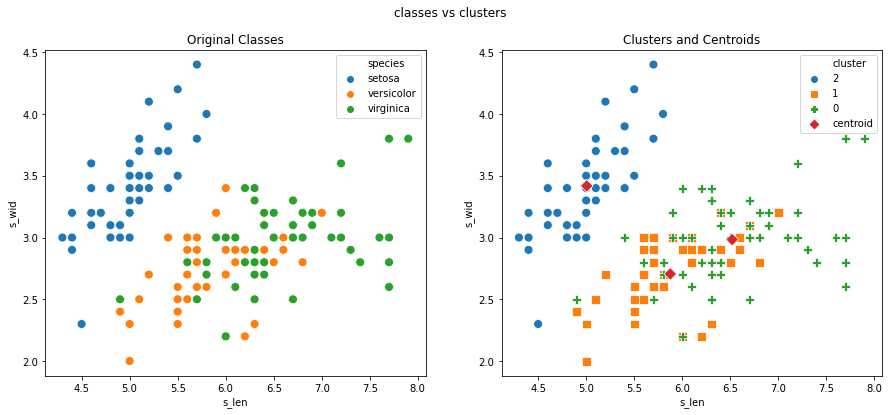

In [15]:
plt.figure(figsize=(15,6))
plt.suptitle("classes vs clusters")
plt.subplot(121)
plt.title("Original Classes")
sns.scatterplot("s_len","s_wid",data=all_df,hue="species",s=80)
plt.legend(loc="upper right")

plt.subplot(122)
plt.title("Predicted Clusters and Centroids")
sns.scatterplot(
    "s_len","s_wid",data=all_df,
    hue="cluster",style = "cluster",
    markers="osPD",s=80
)
plt.legend(loc="upper right")

plt.show()

 ## Test out multiple values for k

In [25]:
sil_coefs = []
distortions = []
K = np.arange(2,6)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_x)
    avg_sil_coef = silhouette_score(train_x,kmeans.labels)
    dist = distortion(train_x,kmeans.labels,kmeans.centroids)
    print(f"For k={k:<4} Avg.Sil.Coef: {avg_sil_coef:<10.5f} Distortion: {dist:.5f}")
    distortions.append(dist)
    sil_coefs.append(avg_sil_coef)

For k=2    Avg.Sil.Coef: 0.41657    Distortion: 1.30604
For k=3    Avg.Sil.Coef: 0.49127    Distortion: 0.67576
For k=4    Avg.Sil.Coef: 0.45307    Distortion: 0.59402
For k=5    Avg.Sil.Coef: 0.32360    Distortion: 0.56721


 ## Elbow method plot

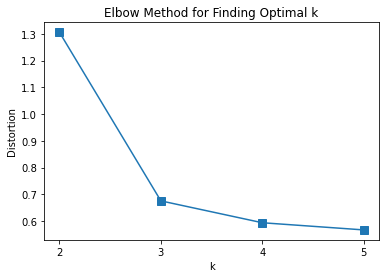

In [26]:
plt.plot(K, distortions, 's-', markersize=8)
plt.xlabel('k')
plt.xticks(K)
plt.ylabel('Distortion')
plt.title('Elbow Method for Finding Optimal k')
plt.show()

 ## Implementation with scikit learn

In [19]:
from sklearn.cluster import KMeans as sklKMeans
from sklearn.metrics import silhouette_score as sk_silhouette_score

In [12]:
k = 3
kmeans = sklKMeans(n_clusters=k, init='random').fit(train_x)
ss = sk_silhouette_score(train_x, kmeans.labels_)
dist = distortion(train_x,kmeans.labels_, kmeans.cluster_centers_)
print(f"For k={k}\tAvg. Sil. Coef: {ss:.5f}\tDistortion: {dist:.5f}")

For k=3	Avg. Sil. Coef: 0.55259	Distortion: 0.64884


 # GMM

In [22]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [107]:
class GMM:
    def __init__(self, n_components: int):
        self.n_components = n_components

    def fit(
        self, X,  n_iters: int, tol: float, 
        random_state: int=0, 
        means="random",
        plot_params={}
    ):
        m,n= X.shape
        self.X = X
        k = self.n_components
        
        self.resp = np.zeros((m, k))
        self.weights = np.full(k, 1 / k)
        
        
        if means == "kmeans":
            kmeans = KMeans(k)
            kmeans.fit(X)
            self.means = kmeans.centroids
        else :
            np.random.seed(random_state)
            self.means = X[np.random.choice(m, k , replace=False)]
            

        self.covs = np.full((k, n, n), np.cov(X, rowvar=False))
    
        self.converged = False
        self.log_likelihood_trace = [0]
    
        fig,ax = plt.subplots(1,4,figsize=(20,5))
        fig.suptitle("GMM Using Estimation and Maximization")
        self.draw(ax[0],"Initial Clusters", **plot_params)
        
        for i in range(self.n_iters):
            log_likelihood= self._do_estep(X)
            self._do_mstep(X)
            if i == 0:
                self.draw(ax[1],"Clusters after 1 iteration", **plot_params)
            
            self.log_likelihood_trace.append(log_likelihood)
            if abs(log_likelihood - self.log_likelihood_trace[-2]) <= self.tol:
                self.converged = True
                break
        self.log_likelihood_trace = self.log_likelihood_trace[1:]

        self.draw(ax[2],f"clusters after {i} iterations", **plot_params)
        ax[3].plot(self.log_likelihood_trace, "-s")
        ax[3].set_title("Log Likelihood")
        plt.show()
        return self

    def _do_estep(self, X):
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis=1)))
        self.resp = self.resp / self.resp.sum(axis=1, keepdims=1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

    def _do_mstep(self, X):
        resp_weights = self.resp.sum(axis=0)
        self.weights = resp_weights / X.shape[0]
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]

        return self

    def draw(self,ax,  title="", **plot_params):
        ax.set_title(title)
        ax.scatter(self.X[:, 0], self.X[:, 1],**plot_params)
        
        delta = 0.05
        k = self.n_components
        x = np.arange(*ax.get_xlim(), delta)
        y = np.arange(*ax.get_ylim(), delta)
        x, y = np.meshgrid(x, y)
        col = [f"C{(i+1)%10}" for i in range(k)]
        for i in range(k):
            mean, cov = self.means[i], self.covs[i]
            z = multivariate_normal(mean, cov).pdf(np.dstack([x, y]))
            ax.scatter(mean[0], mean[1], color=col[i])
            ax.contour(x, y, z, levels=[.01], colors=col[i])

def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10],seed = 1):
    np.random.seed(seed)
    x = np.ndarray((k,points_per_cluster,dim))
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = cov @ cov.T
        x[i] = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
    x = x.reshape(-1,dim)

    if(dim == 2):
        plt.figure()
        plt.title("generated random gaussian distributions")
        plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.4)
        plt.show()
        
    return x

 # GMM on random data using random means

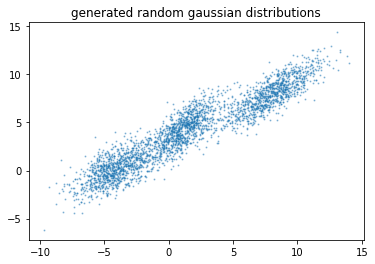

In [108]:
X = gen_data(k=3, dim=2, points_per_cluster=1000, seed=3)

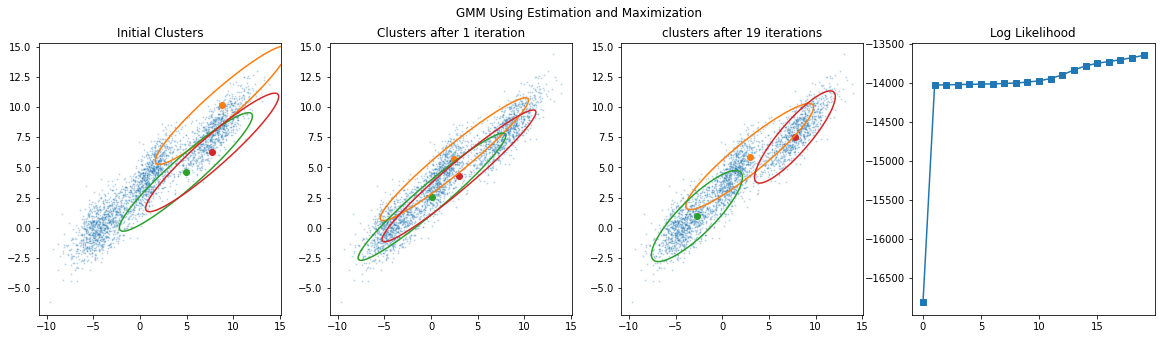

In [106]:
gmm = GMM(3, 20,10e-4, 5)
gmm.fit(X, plot_params={"s":1,"alpha":.2})

 # GMM by using kmeans to initialize means

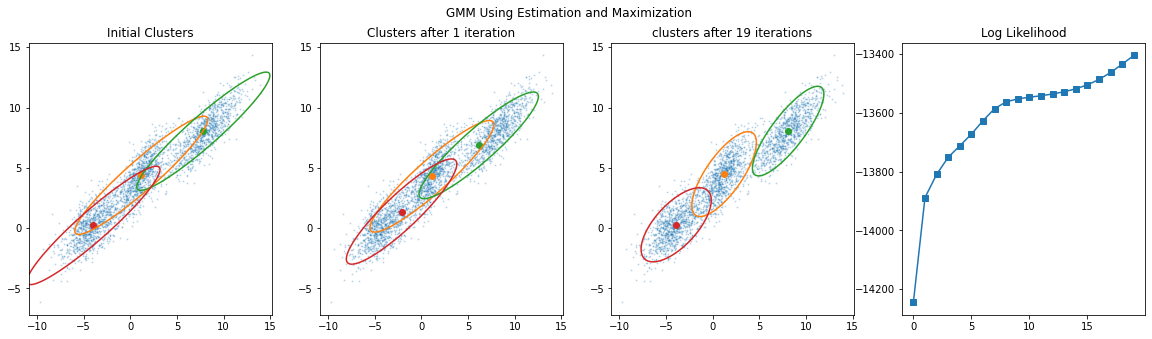

In [102]:
# X = train_x[...,(0,2)]
k = 3
kmeans = KMeans(k)
kmeans.fit(X,random_state=1)
gmm = GMM(k,20,10e-4,5)
gmm.fit(X,kmeans.centroids,plot_params={"s":1,"alpha":.2})
